In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

from pathlib import Path

import os
cwd=os.getcwd()

path_lcp = cwd + '/hubel.dat'
lcp_file = Path(path_lcp)


if lcp_file.is_file():

    lcp = np.genfromtxt(path_lcp)
                
    z_obs = lcp[:,0]
    H_obs = lcp[:,1]
    dH_obs = lcp[:,2] 

    print("H data are loaded")   
    
else:
    print("H files do not exist")
    sys.exit(0) 



H data are loaded


In [33]:
X = z_obs.reshape(-1,1)
const_func = pm.gp.mean.Constant(2.)
lin_func = pm.gp.mean.Linear(coeffs=70, intercept=3*70)

pri_mean = lin_func

with pm.Model() as model:
    les = pm.Uniform("ℓ", lower=0.01, upper=5)
    eta = pm.Uniform("η", lower=0.01,upper=200)

    cov = eta**2 * pm.gp.cov.ExpQuad(1, les)
    gp1 = pm.gp.Marginal(mean_func=pri_mean,cov_func=cov)

    like = gp1.marginal_likelihood("y", X=X, y=H_obs, noise=dH_obs)

    mp1 = pm.find_MAP()
    #trace = pm.sample(draws=5000,tune=1000, cores=2)

/home/ahmad/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [34]:
X = z_obs.reshape(-1,1)
const_func = pm.gp.mean.Constant(0.)
lin_func = pm.gp.mean.Linear(coeffs=70, intercept=4*70)

pri_mean = const_func

with pm.Model() as model:
    les = pm.Uniform("ℓ", lower=0.01, upper=5)
    eta = pm.Uniform("η", lower=0.01,upper=200)

    cov = eta**2 * pm.gp.cov.ExpQuad(1, les)
    gp2 = pm.gp.Marginal(mean_func=pri_mean,cov_func=cov)

    like = gp2.marginal_likelihood("y", X=X, y=H_obs, noise=dH_obs)

    mp2 = pm.find_MAP()
    #trace = pm.sample(draws=5000,tune=1000, cores=2)

/home/ahmad/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [35]:
print(float(mp1["ℓ"]))
print(float(mp1["η"]))
print(float(mp2["ℓ"]))
print(float(mp2["η"]))
#print(pm.summary(trace))
#pm.traceplot(trace, figsize=(12, 5));

1.5278599951100866
117.10499182174595
1.9446214318754635
155.61038152366373


In [19]:
X_new = np.linspace(0, 3, 600)[:, None]

/home/ahmad/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


0.14896770752592056
0.1357721426139621


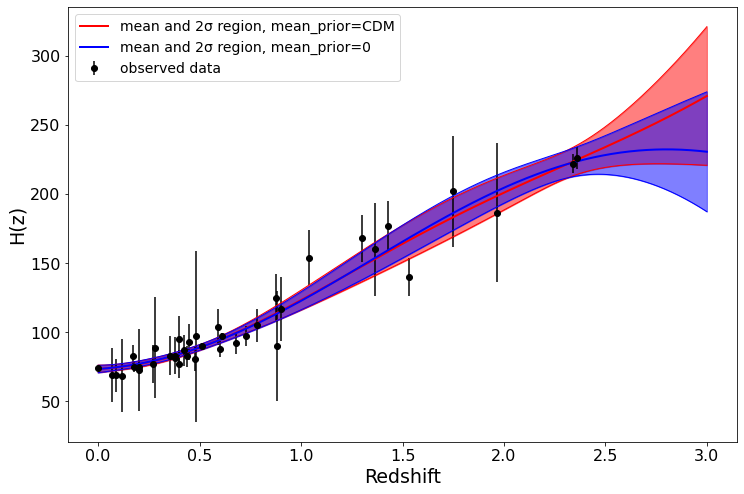

In [43]:
plt.rcParams['figure.figsize'] = (12,8)

mu1, var1 = gp1.predict(X_new,point=mp1, diag=True)
sd1 = np.sqrt(var1)

mu2, var2 = gp2.predict(X_new,point=mp2, diag=True)
sd2 = np.sqrt(var2)

# draw plot
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_new, mu1, "r", lw=2, label="mean and 2σ region, mean_prior=CDM")
plt.plot(X_new, mu1 + 2 * sd1, "r", lw=1)
plt.plot(X_new, mu1 - 2 * sd1, "r", lw=1)
plt.fill_between(X_new.flatten(), mu1 - 2 * sd1, mu1 + 2 * sd1, color="r", alpha=0.5)

plt.plot(X_new, mu2, "b", lw=2, label="mean and 2σ region, mean_prior=0")
plt.plot(X_new, mu2 + 2 * sd2, "b", lw=1)
plt.plot(X_new, mu2 - 2 * sd2, "b", lw=1)
plt.fill_between(X_new.flatten(), mu2 - 2 * sd2, mu2 + 2 * sd2, color="b", alpha=0.5)

# plot original data and true function
plt.errorbar(X, H_obs,yerr=dH_obs, fmt='ko', label="observed data")
#plt.plot(X, f_true, "dodgerblue", lw=3, label="true f")

plt.xlabel("Redshift",fontsize=19)
plt.ylabel("H(z)",fontsize=19)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.ylim([-13, 13])
#plt.title("predictive mean and 2σ interval")
plt.legend(fontsize=14);
plt.savefig("gp.pdf")

print((mu1[-1] - mu2[-1])/mu1[-1])
print((sd1[-1] - sd2[-1])/sd1[-1])


In [ ]:
# define a custome mean function

import theano.tensor as tt

class Constant(pm.gp.mean.Mean):

    def __init__(self, c=0):
        Mean.__init__(self)
        self.c = c

    def __call__(self, X):
        return tt.alloc(1.0, X.shape[0]) * self.c